# Supplemental Figure S3: Diversity of two-way junctions

# Setup

## imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dms_3d_features.plotting import *

## extra functions

## load data

In [3]:
DATA_PATH = "../../data"
REVISION_PATH = "../../data/revisions"

# Plotting

In [4]:
df_fig_1 = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df_fig_1 = df_fig_1.query("r_type != 'WC'").copy()
df_fig_1 = df_fig_1.query("r_data_outlier == False").copy()

with np.errstate(divide="ignore"):
    df_fig_1["ln_r_data"] = np.log(df_fig_1["r_data"])
df_fig_1["ln_r_data"].replace(-np.inf, -9.8, inplace=True)
# Group the data and calculate statistics
df_second_stack = (
    df_fig_1.groupby(
        ["m_sequence", "r_loc_pos", "m_second_flank_bp_5p", "m_second_flank_bp_3p"]
    )
    .agg(
        m_token=("m_token", "first"),
        likely_pair=("likely_pair", "first"),
        m_flank_bp_5p=("m_flank_bp_5p", "first"),
        m_flank_bp_3p=("m_flank_bp_3p", "first"),
        p5_res=("p5_res", "first"),
        p3_res=("p3_res", "first"),
        r_stack=("r_stack", "first"),
        mean_ln_r_data=("ln_r_data", "mean"),
        std_ln_r_data=("ln_r_data", "std"),
        cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
        count=("ln_r_data", "count"),
        r_type=("r_type", "first"),
    )
    .reset_index()
)

In [6]:
df_sub = pd.read_csv(f"{DATA_PATH}/csvs/randomized_cvs.csv")

In [7]:
df_cv = (
    df_fig_1.groupby(["m_sequence", "r_loc_pos"])
    .agg(
        cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
        r_type=("r_type", "first"),
    )
    .reset_index()
)
df_cv["data_type"] = "None"
df_second_stack_cv = df_second_stack.query("count >= 5").copy()
df_second_stack_cv["data_type"] = "Second Stack"
df_sub["data_type"] = "Random"
df_all = pd.concat([df_second_stack_cv, df_cv, df_sub]).reset_index(drop=True)

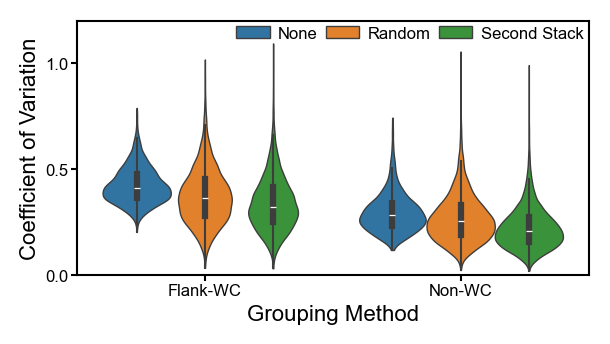

In [8]:
fig, ax = plt.subplots(figsize=(1.65 * 2, 1.65), dpi=200)

# Create violin plot
sns.violinplot(
    data=df_all,
    x="r_type",
    y="cv_r_data",
    hue="data_type",
    order=["Flank-WC", "NON-WC"],
    hue_order=["None", "Random", "Second Stack"],
    linewidth=0.5,
    cut=0,
    ax=ax,
)

ax.set_xticks([0, 1])
ax.set_xticklabels(["Flank-WC", "Non-WC"])
ax.set_ylim(0, 1.2)
ax.set_xlabel("Grouping Method", labelpad=2)
ax.set_ylabel("Coefficient of Variation", labelpad=2)

# Adjust legend
plt.legend(
    loc="upper right",
    ncol=3,
    fontsize=6,
    prop={"family": "Arial", "size": 6},
    frameon=False,
    handletextpad=0.5,  # decrease space between columns
    columnspacing=0.5,  # decrease space between columns
    borderaxespad=-0.10,  # as close as possible to axes
)
publication_style_ax(ax)
plt.savefig(
    "../../figures/supplemental_figures/supplemental_figure_s7.png",
    bbox_inches="tight",
    dpi=600,
)